In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from copy import deepcopy

from importlib import reload

import time
import pickle

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import optimizor

from optimizor import eta_2_Gamma
from optimizor import Gamma_2_eta
from optimizor import logdotexp

In [3]:
sys.path

['/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src',
 '/Users/evsi8432/anaconda3/lib/python37.zip',
 '/Users/evsi8432/anaconda3/lib/python3.7',
 '/Users/evsi8432/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/evsi8432/.local/lib/python3.7/site-packages',
 '/Users/evsi8432/anaconda3/lib/python3.7/site-packages',
 '/Users/evsi8432/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/evsi8432/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/evsi8432/.ipython']

# Initialize Parameters

In [4]:
# make parameters
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 1000

# Simulate Data

In [5]:
N = 3
X = np.zeros(T,dtype=int)
data = []

# define parameters
Gamma = np.array([[0.5,0.25,0.25],
                  [0.25,0.5,0.25],
                  [0.25,0.25,0.5]])
delta = np.ones(pars.K[0])/pars.K[0]

mus = [-1,0,1]
sigs = [1.0,1.0,1.0]

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

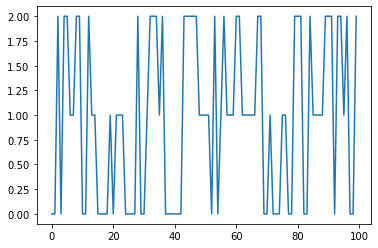

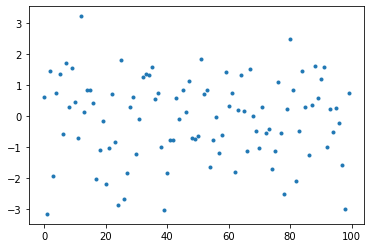

In [6]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# Initialize optimizor and select intial values

In [7]:
# initialize objects
hhmm = HHMM.HHMM(pars,data)

hhmm.theta = [{'Y': {'mu': np.array([-2.0,  -1.0,  0.0]),
                     'log_sig': np.array([0.0, 0.0, 0.0]),
                     'corr': np.array([0.0, 0.0, 0.0])}},
               [{}, {}, {}]]

hhmm.Gamma = [np.array([[0.50, 0.25, 0.25],
                        [0.25, 0.50, 0.25],
                        [0.25, 0.25, 0.50]]),
               [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

hhmm.eta = Gamma_2_eta(hhmm.Gamma)

In [8]:
#L = 0.5*(4/np.exp(0))**2 # lipschitz constant

optim1 = optimizor.optimizor(hhmm)
optim1.step_size = 5e-2
optim1.param_bounds["Y"]["mu"] = [-2,2]
optim1.param_bounds["Y"]["log_sig"] = [-1,1]

# set theta and eta to true values
optim2 = optimizor.optimizor(hhmm)
optim2.step_size = 5e-2 / T
optim2.param_bounds["Y"]["mu"] = [-2,2]
optim2.param_bounds["Y"]["log_sig"] = [-1,1]

# print values
print(optim1.theta)
print(optim1.eta)
print(optim1.param_bounds)
print(optim1.step_size)

[{'Y': {'mu': array([-2., -1.,  0.]), 'log_sig': array([0., 0., 0.]), 'corr': array([0., 0., 0.])}}, [{}, {}, {}]]
[array([[ 0.        , -0.69314718, -0.69314718],
       [-0.69314718,  0.        , -0.69314718],
       [-0.69314718, -0.69314718,  0.        ]]), [array([[0.]]), array([[0.]]), array([[0.]])]]
{'Y': {'mu': [-2, 2], 'log_sig': [-1, 1]}}
0.05


# Train the HMM

In [9]:
# do first optimization
num_epochs = 10
optim1.step_num = 1
optim1.train_HHMM(num_epochs,decay_ind=np.infty)

# do second optimization
num_epochs = 10
optim2.step_num = 1
optim2.train_HHMM(num_epochs,h=1,decay_ind=np.infty)

finished epoch num:  0
last direction:  forward
log-likelihood:  -187.53141073554917
finished epoch num:  1
last direction:  backward
log-likelihood:  -177.68121789670812
finished epoch num:  2
last direction:  forward
log-likelihood:  -167.3820766737099
finished epoch num:  3
last direction:  backward
log-likelihood:  -167.03530657298586
finished epoch num:  4
last direction:  forward
log-likelihood:  -166.86558521930314
finished epoch num:  5
last direction:  backward
log-likelihood:  -166.81415297330636
finished epoch num:  6
last direction:  forward
log-likelihood:  -166.76656791930822
finished epoch num:  7
last direction:  backward
log-likelihood:  -166.74590853838384
finished epoch num:  8
last direction:  forward
log-likelihood:  -166.72640757564062
finished epoch num:  9
last direction:  backward
log-likelihood:  -166.71696738047143
finished epoch num:  10
last direction:  forward
log-likelihood:  -166.7078148613478
finished epoch num:  11
last direction:  backward
log-likelih

finished epoch num:  95
last direction:  backward
log-likelihood:  -166.6893115772697
finished epoch num:  96
last direction:  forward
log-likelihood:  -166.68931157726965
finished epoch num:  97
last direction:  backward
log-likelihood:  -166.68931157726962
finished epoch num:  98
last direction:  forward
log-likelihood:  -166.68931157726965
finished epoch num:  99
last direction:  backward
log-likelihood:  -166.68931157726962
finished epoch num:  0
last direction:  forward
log-likelihood:  -178.2918557753614
finished epoch num:  1
last direction:  backward
log-likelihood:  -179.80746897131058
finished epoch num:  2
last direction:  forward
log-likelihood:  -177.828974817311
finished epoch num:  3
last direction:  backward
log-likelihood:  -175.35437129838195
finished epoch num:  4
last direction:  forward
log-likelihood:  -169.14033708277208
finished epoch num:  5
last direction:  backward
log-likelihood:  -169.0554940087126
finished epoch num:  6
last direction:  forward
log-likelih

finished epoch num:  94
last direction:  forward
log-likelihood:  -166.2925879493938
finished epoch num:  95
last direction:  backward
log-likelihood:  -167.4924590425156
finished epoch num:  96
last direction:  forward
log-likelihood:  -167.4591967620601
finished epoch num:  97
last direction:  backward
log-likelihood:  -166.30349572801376
finished epoch num:  98
last direction:  forward
log-likelihood:  -167.2954532813185
finished epoch num:  99
last direction:  backward
log-likelihood:  -167.2019832446284


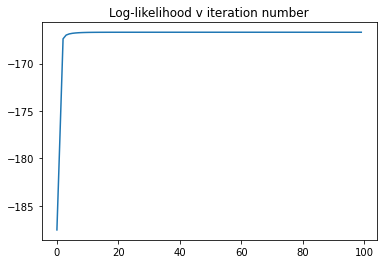

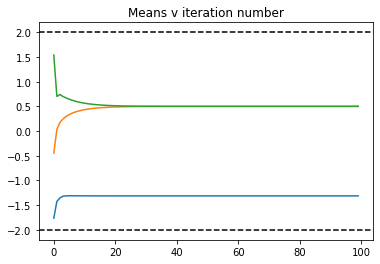

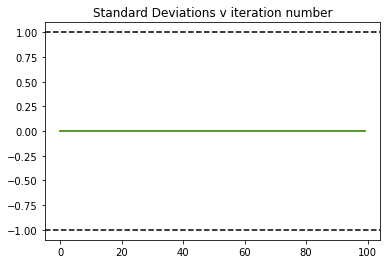

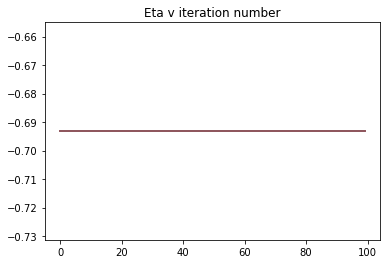

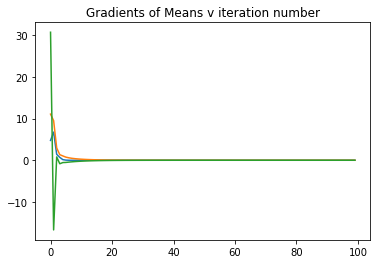

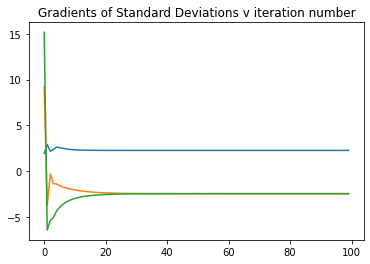

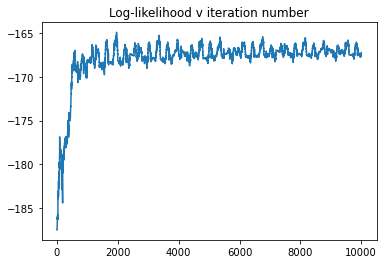

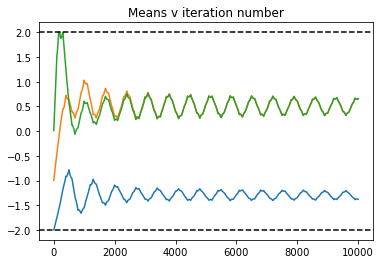

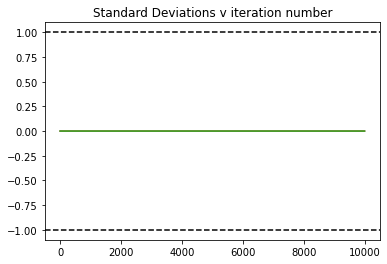

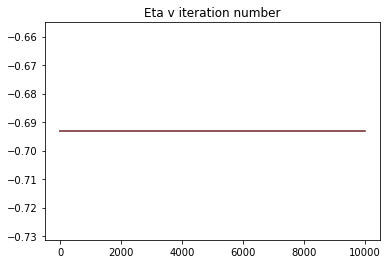

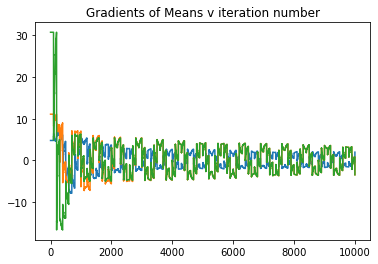

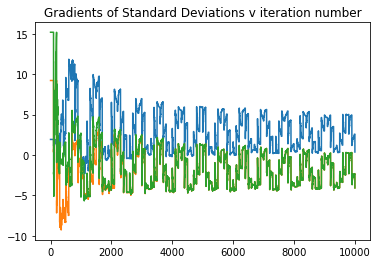

In [10]:
def plot_results(optim):
    plt.plot(optim.log_like_trace)
    plt.title("Log-likelihood v iteration number")
    plt.show()

    plt.plot([optim.theta_trace[i][0]['Y']['mu'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][2] for i in range(len(optim.theta_trace))])
    plt.title("Means v iteration number")
    plt.axhline(optim.param_bounds['Y']['mu'][0], c = 'k', linestyle = "--")
    plt.axhline(optim.param_bounds['Y']['mu'][1], c = 'k', linestyle = "--")
    plt.show()
    
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    plt.axhline(optim.param_bounds['Y']['log_sig'][0], c = 'k', linestyle = "--")
    plt.axhline(optim.param_bounds['Y']['log_sig'][1], c = 'k', linestyle = "--")
    plt.title("Standard Deviations v iteration number")
    plt.show()
    
    plt.plot([optim.eta_trace[i][0][0,1] for i in range(len(optim.eta_trace))])
    plt.plot([optim.eta_trace[i][0][0,2] for i in range(len(optim.eta_trace))])
    plt.plot([optim.eta_trace[i][0][1,0] for i in range(len(optim.eta_trace))])
    plt.plot([optim.eta_trace[i][0][1,2] for i in range(len(optim.eta_trace))])
    plt.plot([optim.eta_trace[i][0][2,0] for i in range(len(optim.eta_trace))])
    plt.plot([optim.eta_trace[i][0][2,1] for i in range(len(optim.eta_trace))])
    plt.title("Eta v iteration number")
    plt.show()

    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][2] for i in range(len(optim.theta_trace))])
    plt.title("Gradients of Means v iteration number")
    plt.show()
    
    plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    plt.title("Gradients of Standard Deviations v iteration number")
    plt.show()
    
plot_results(optim1)
plot_results(optim2)

# Make sure that the likelihoods agree

-154.07906064574885



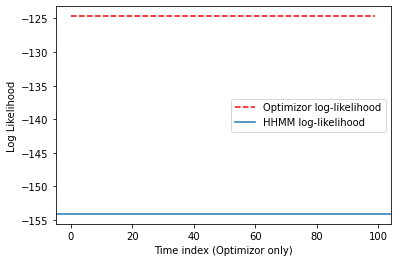

In [11]:
# using hhmm
print(hhmm.likelihood(data))
print("")
# do a forward pass and backwards pass
optim1.fwd_pass()
optim1.bwd_pass()

# print likelihood of evaluated at each time point
lls = [optim1.log_likelihood(t) for t in range(optim1.T)]
plt.plot(lls,"r--")
plt.axhline(hhmm.likelihood(data))
plt.legend(["Optimizor log-likelihood","HHMM log-likelihood"])
plt.xlabel("Time index (Optimizor only)")
plt.ylabel("Log Likelihood")
plt.show()

# Test that the gradients wrt $\theta$ agree

In [12]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_theta[t][0]["Y"]["mu"][2]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.theta[0]['Y']['mu'][2] += eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.theta[0]['Y']['mu'][2] += -eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
plt.plot(autograds)
plt.plot(finite_diffs)

NameError: name 'optim' is not defined

# Test that the gradients wrt $\eta$ agree

In [ ]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_eta[t][0,1]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.eta[0][0,1] += eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.eta[0][0,1] += -eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
print(autograds)
print(finite_diffs)
plt.plot(autograds)
plt.plot(finite_diffs)

In [ ]:
np.clip(np.array([-1,0,1]),-0.5,0.5)